In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np

In [2]:
IMAGE_SIZE = 256
CHANNELS = 3
BATCH_SIZE = 32
EPOCHS = 50
N_CLASSES = 4

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
  "D:\Project\Orange Disease",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1783 files belonging to 4 classes.


In [4]:
class_names = dataset.class_names
class_names

['blackspot', 'canker', 'fresh', 'grenning']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[3 2 3 0 0 2 0 2 1 2 2 2 2 2 3 0 2 3 2 2 2 2 1 2 1 3 3 0 3 2 2 3]


In [6]:
# Create a mapping between numerical labels and class names
class_names = {0: 'blackspot', 1: 'canker', 2: 'fresh',3:'grenning'}

unique_labels = set()

for _, labels_batch in dataset.take(1):
    unique_labels.update(labels_batch.numpy())

print("Unique Labels/Classes in the Dataset:", unique_labels)

# Convert numerical labels to class names for visualization
class_names_batch = [class_names[label] for label in labels_batch.numpy()]


Unique Labels/Classes in the Dataset: {0, 1, 2, 3}


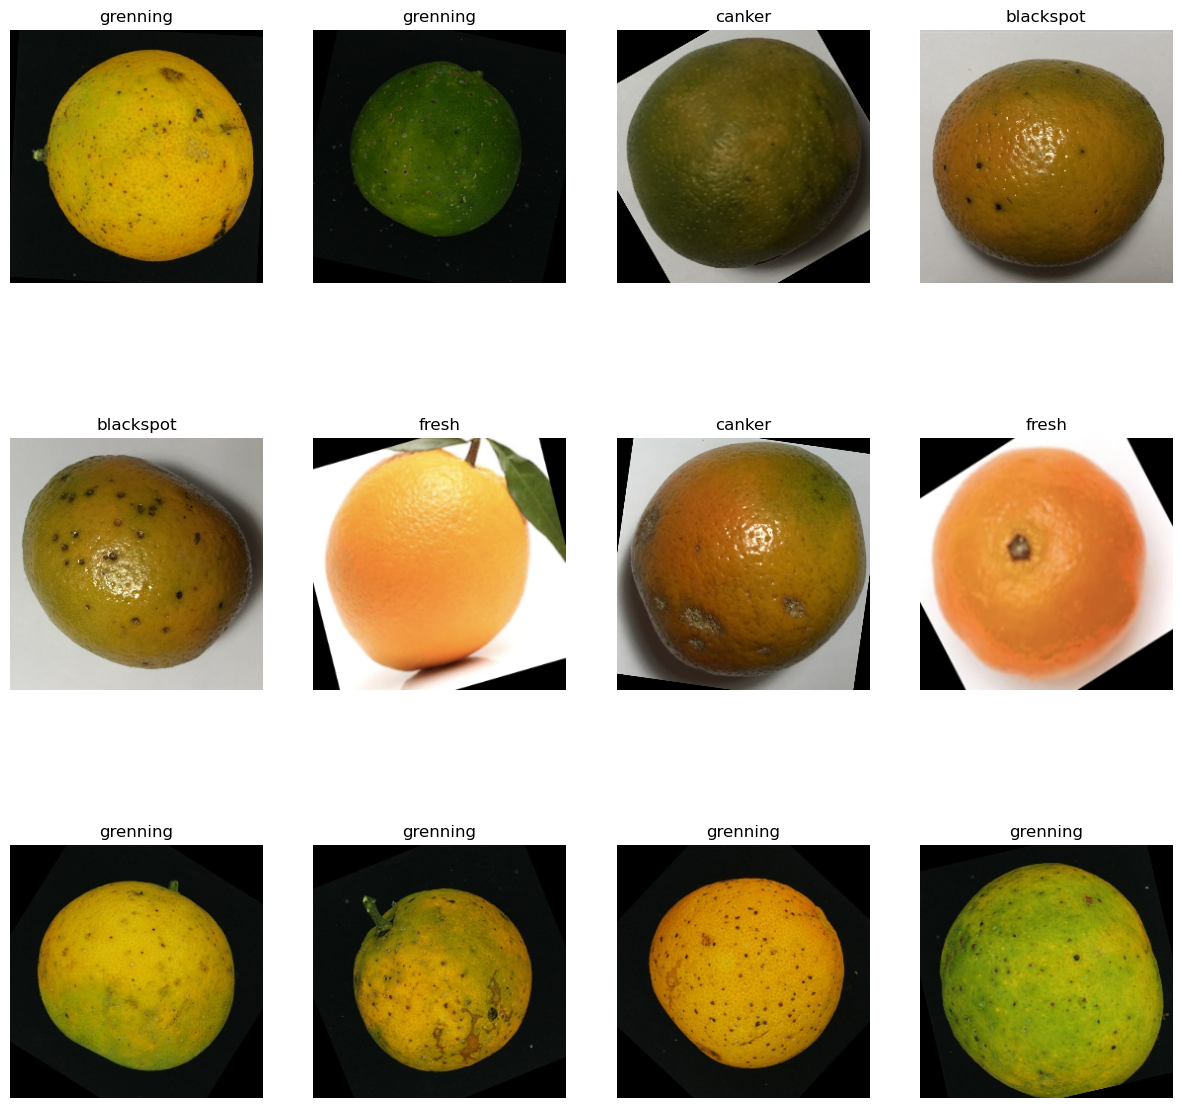

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))
for image_batch, labels_batch in dataset.take(3):  # Display examples from 3 batches
    labels_batch_np = labels_batch.numpy()  # Convert the entire labels_batch tensor to a NumPy array
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)  # 3 batches * 4 subplots per batch
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        
        # Use the NumPy array as an index in the class_names dictionary
        label_key = labels_batch_np[i]
        plt.title(class_names[label_key])
        
        plt.axis("off")

plt.show()

In [8]:
len(dataset)

56

In [9]:
train_size = 0.8
len(dataset)*train_size

44.800000000000004

In [19]:
train_ds = dataset.take(44)
len(train_ds)

44

In [20]:
test_ds = dataset.skip(44)
len(test_ds)

12

In [21]:
val_size=0.1
len(dataset)*val_size

5.6000000000000005

In [22]:
test_ds = test_ds.skip(5)
len(test_ds)

7

In [23]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [24]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [25]:
len(train_ds)

44

In [26]:
len(val_ds)

5

In [27]:
len(test_ds)

7

In [28]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [29]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [30]:
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.4), 
])

In [31]:
train_ds_augmented = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [32]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [33]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [34]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=10,  # Adjust the patience parameter
    restore_best_weights=True,
    monitor='val_loss'
)

In [35]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # Adjust the learning rate
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [36]:
history = model.fit(
    train_ds_augmented,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
    callbacks=[early_stopping]
)

Epoch 1/50
44/44 [==============================] - 42s 875ms/step - loss: 0.6539 - accuracy: 0.7507 - val_loss: 0.2263 - val_accuracy: 0.8687
Epoch 2/50
44/44 [==============================] - 36s 822ms/step - loss: 0.3071 - accuracy: 0.8700 - val_loss: 0.2017 - val_accuracy: 0.8875
Epoch 3/50
44/44 [==============================] - 36s 824ms/step - loss: 0.2253 - accuracy: 0.8935 - val_loss: 0.2170 - val_accuracy: 0.8687
Epoch 4/50
44/44 [==============================] - 36s 819ms/step - loss: 0.2407 - accuracy: 0.8786 - val_loss: 0.1777 - val_accuracy: 0.9062
Epoch 5/50
44/44 [==============================] - 36s 827ms/step - loss: 0.2045 - accuracy: 0.9055 - val_loss: 0.1426 - val_accuracy: 0.9625
Epoch 6/50
44/44 [==============================] - 35s 807ms/step - loss: 0.2735 - accuracy: 0.8651 - val_loss: 0.2146 - val_accuracy: 0.9000
Epoch 7/50
44/44 [==============================] - 36s 821ms/step - loss: 0.2162 - accuracy: 0.8913 - val_loss: 0.1724 - val_accuracy: 0.9187

In [37]:
scores = model.evaluate(test_ds)

7/7 [==============================] - 2s 190ms/step - loss: 0.0547 - accuracy: 0.9821


In [38]:
score = model.evaluate(train_ds)

44/44 [==============================] - 9s 195ms/step - loss: 0.0535 - accuracy: 0.9808


In [39]:
scores

[0.054728858172893524, 0.9821428656578064]

In [40]:
tf.keras.callbacks.History()

In [41]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 44}

In [42]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [43]:
type(history.history['loss'])

list

In [44]:
len(history.history['loss'])

39

In [45]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.6538872718811035,
 0.30709126591682434,
 0.22534294426441193,
 0.24069347977638245,
 0.20448201894760132]

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

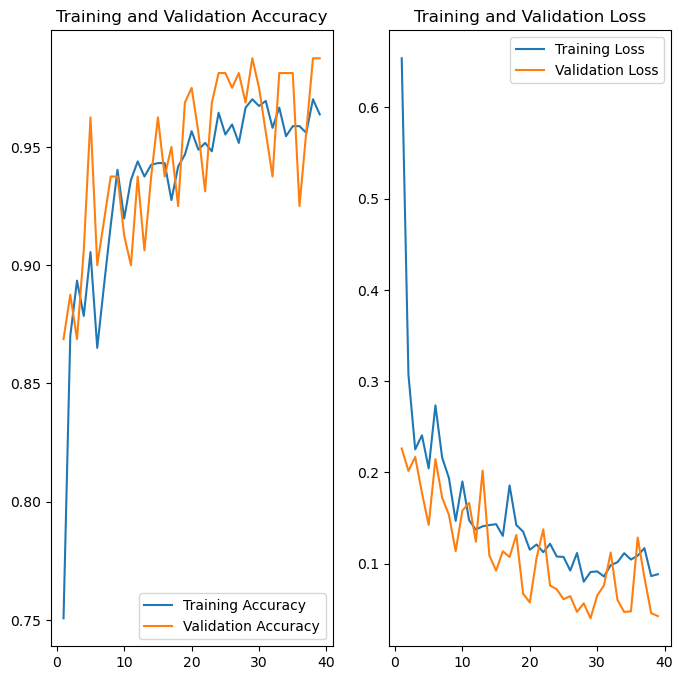

In [47]:
epochs = range(1, len(acc) + 1)  

plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

first image to predict
actual label: fresh
1/1 [==============================] - 0s 476ms/step
predicted label: fresh


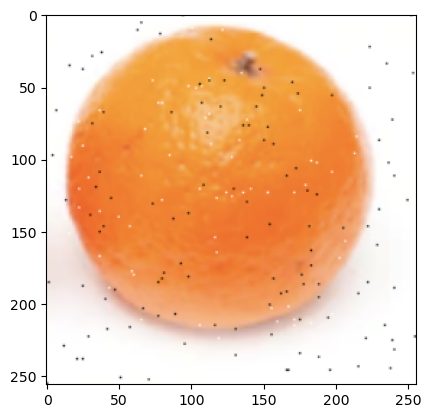

In [48]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])
    

In [49]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 25ms/step


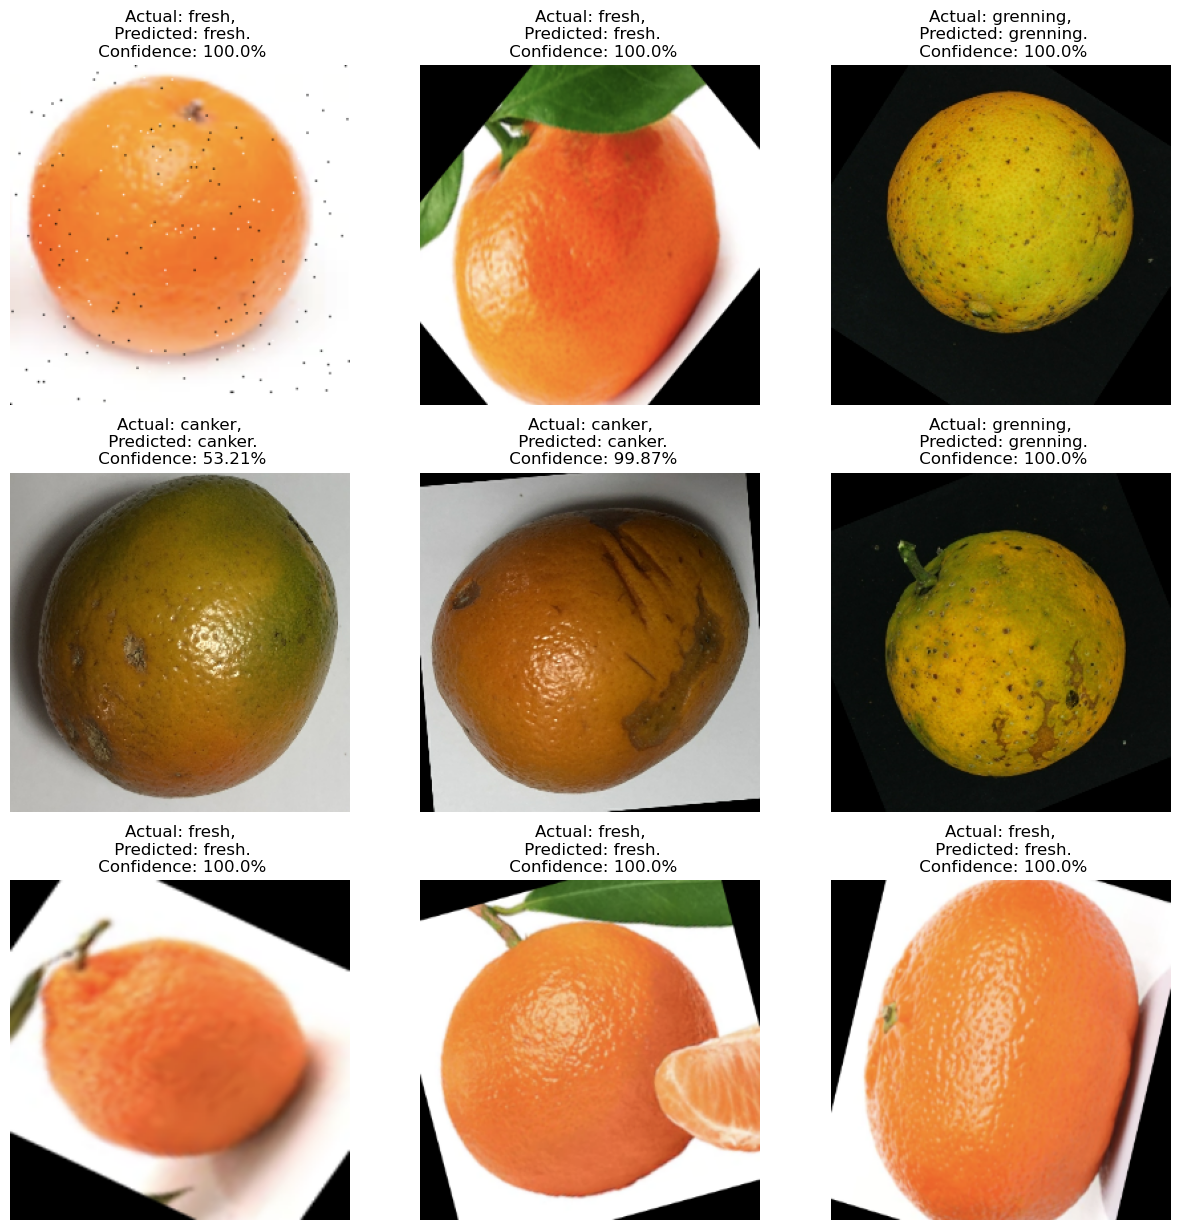

In [50]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i].numpy()]

        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [51]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
import numpy as np
from sklearn.preprocessing import LabelEncoder

true_labels = []
predicted_labels = []

# Create a LabelEncoder instance
label_encoder = LabelEncoder()

# Collect all unique class names from the training dataset
all_class_names = ['blackspot', 'canker', 'fresh', 'grenning']
label_encoder.fit(all_class_names)  

# Iterate through the test dataset to collect true and predicted labels
for images, labels in test_ds:
    for i in range(len(images)):
        try:
            true_labels.append(label_encoder.transform([class_names[labels[i].numpy()]])[0])
        except KeyError:
            # Handle unseen label gracefully
            print(f"Unseen label: {class_names[labels[i].numpy()]}")
            continue
        
        # Using your predict function
        predicted_class, _ = predict(model, images[i].numpy())
        predicted_labels.append(label_encoder.transform([predicted_class])[0])

# Convert lists to numpy arrays for precision calculation
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Calculate precision, recall, and f1-score with zero_division parameter
precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=1)
recall = recall_score(true_labels, predicted_labels, average='weighted', zero_division=1)
f1 = f1_score(true_labels, predicted_labels, average='weighted', zero_division=1)

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')


1/1 [==============================] - 0s 26ms/step
Precision: 0.98
Recall: 0.98
F1-score: 0.98


In [52]:
# Calculate precision with zero_division parameter
precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=1)

print(f'Precision: {precision:.2f}')


Precision: 0.98


In [53]:
# Calculate recall with zero_division parameter
recall = recall_score(true_labels, predicted_labels, average='weighted', zero_division=1)

print(f'Recall: {recall:.2f}')

Recall: 0.98


In [54]:
# Calculate precision with zero_division parameter
f1 = f1_score(true_labels, predicted_labels, average='weighted', zero_division=1)
print(f'F1-score: {f1:.2f}')

F1-score: 0.98


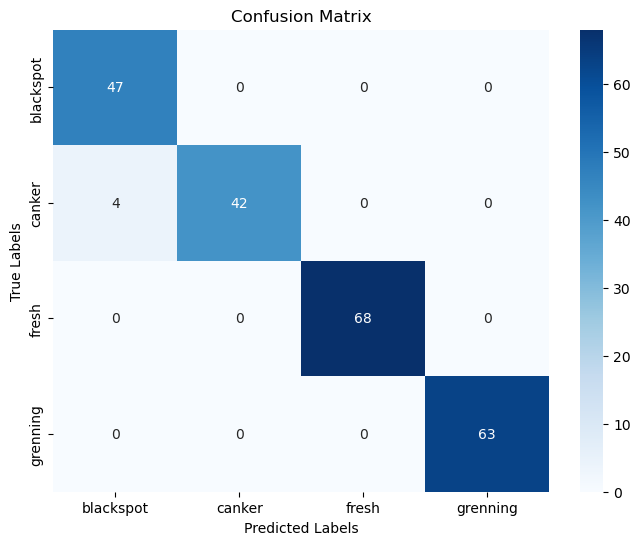

In [55]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have true_labels and predicted_labels

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Define class names for visualization
class_names = ['blackspot', 'canker', 'fresh', 'grenning']

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [56]:
model.save("D:\Project\MODELS4\Orange_disease.h5")

In [57]:
keras_model = tf.keras.models.load_model("D:\Project\MODELS4\Orange_disease.h5")

In [58]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\HP\AppData\Local\Temp\tmpyo4mgp3p\assets


INFO:tensorflow:Assets written to: C:\Users\HP\AppData\Local\Temp\tmpyo4mgp3p\assets


In [59]:
with open("D:\Project\MODELS\Orange_disease.tflite", "wb") as tflite_file:
    tflite_file.write(tflite_model)